# Walter 1994

In [23]:
from pathlib import Path
import os
from modflowapi.extensions import ApiSimulation
from modflowapi import Callbacks
# from workflow import *
from datetime import datetime
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#add mf6rtm path to the system
sys.path.insert(0,os.path.join("..","..","mf6rtm"))
import flopy
import mf6rtm
import utils

prefix = 'walter1994'
DT_FMT = "%Y-%m-%d %H:%M:%S"

# Model Constants

In [24]:
### Model params and setup

# General
length_units = "meters"
time_units = "days"

# Model discretization
nlay = 10  # Number of layers
Lx = 100 #m
ncol = 25 # Number of columns
nrow = 1  # Number of rows
delr = Lx/ncol #10.0  # Column width ($m$)
delc = 1.0  # Row width ($m$)
top = 10.  # Top of the model ($m$)
# botm = 0.0  # Layer bottom elevations ($m$)
zbotm = 0.
botm = np.linspace(top, zbotm, nlay + 1)[1:]

#tdis
nper = 1  # Number of periods
tstep = 20  # Time step ($days$)
perlen = 2000  # Simulation time ($days$)
nstp = perlen/tstep #100.0
dt0 = perlen / nstp
tdis_rc = []
tdis_rc.append((perlen, nstp, 1.0))

#hydraulic properties
prsity = 0.35  # Porosity
k11 = 1.0  # Horizontal hydraulic conductivity ($m/d$)
k33 = k11  # Vertical hydraulic conductivity ($m/d$)
chdspd = [[(0, 0, ncol - 1), 1.]]  # Constant head boundary $m$
strt = np.zeros((nlay, nrow, ncol), dtype=float)*10

l_hd = 12
r_hd = 10
strt[:, 0, 0] = l_hd  # Starting head ($m$)
strt[:, 0, -1] = 10
#transport
dispersivity = 2.5 # Longitudinal dispersivity ($m$)
disp_tr_vert = 0.025 # Transverse vertical dispersivity ($m$)

chdspd = [[(i, 0, 0), l_hd] for i in range(nlay)] # Constant head boundary $m$
chdspd.extend([(i, 0, ncol - 1), r_hd] for i in range(nlay))
icelltype = 1  # Cell conversion type
# ibound = np.ones((nlay, nrow, ncol), dtype=int)
# ibound[:, 0, -1] = -1
# ibound[:, 0, 0] = -1



# Set solver parameter values (and related)
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-6, 1e-6, 1.0
ttsmult = 1.0
dceps = 1.0e-5  # HMOC parameters in case they are invoked
nplane = 1  # HMOC
npl = 0  # HMOC
nph = 4  # HMOC
npmin = 0  # HMOC
npmax = 8  # HMOC
nlsink = nplane  # HMOC
npsink = nph  # HMOC

In [25]:
botm

array([9., 8., 7., 6., 5., 4., 3., 2., 1., 0.])

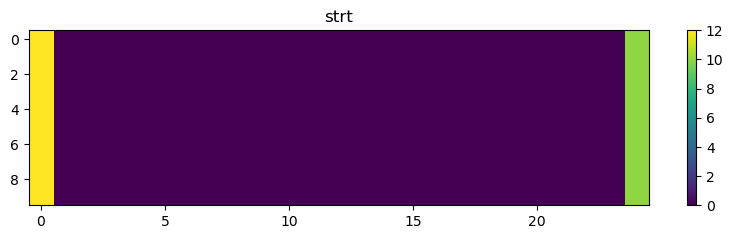

In [26]:
# # make a figure with subplots showing ibound and strt 
fig = plt.figure(figsize=(10, 5))
# ax = fig.add_subplot(2, 1, 1)
# ax.set_title('ibound')
# im = ax.imshow(ibound[:, 0, :], aspect = 'auto')
# cbar = plt.colorbar(im, ax=ax)

ax = fig.add_subplot(2, 1, 2)
ax.set_title('strt')
im = ax.imshow(strt[:, 0, :], aspect = 'auto')
cbar = plt.colorbar(im, ax=ax)


## Initialize Chemistry

In [27]:
dataws = os.path.join("..", "data")

files = [f for f in os.listdir(dataws) if f.startswith(prefix)]

solutionsdf = pd.read_csv(os.path.join(dataws,f"{prefix}_solutions.csv"), comment = '#',  index_col = 0)

# solutions = utils.solution_csv_to_dict(os.path.join(dataws,f"{prefix}_solutions.csv"))
solutions = utils.solution_df_to_dict(solutionsdf)

#get postfix file
postfix = os.path.join(dataws, f'{prefix}_postfix.phqr')
solutionsdf

,sol_bck,sol_tail
comp,,
pH,6.960000e+00,3.990000e+00
pe,1.670000e+00,7.690000e+00
C(+4),3.940000e-03,4.920000e-04
S(6),7.480000e-03,5.000000e-02
S(-2),0.000000e+00,0.000000e+00
Fe(+2),5.390000e-05,3.060000e-02
Fe(+3),2.320000e-08,1.990000e-07
Mn(2),4.730000e-05,9.830000e-06
Ca,6.920000e-03,1.080000e-02


In [28]:
# get equilibrium phases file
equilibrium_phases = utils.equilibrium_phases_csv_to_dict(os.path.join(dataws, f'{prefix}_equilibrium_phases.csv'))
equilibrium_phases

{1: {'Calcite': [0.0, 0.0195],
  'Siderite': [0.0, 0.00422],
  'Gibbsite': [0.0, 0.00251],
  'Fe(OH)3(a)': [0.0, 0.00186],
  'Gypsum': [0.0, 0.0],
  'SiO2(a)': [0.0, 0.407]}}

In [29]:
#assign solutions to grid
sol_ic = np.ones((nlay, nrow, ncol), dtype=int)
#slice nlay = 0 in sol_ic
sol_ic[0,:,:] = 2

#add solutions to clss
solution = mf6rtm.Solutions(solutions)
solution.set_ic(sol_ic)

#create equilibrium phases class
equilibrium_phases = mf6rtm.EquilibriumPhases(equilibrium_phases)
eqp_ic = np.ones((nlay, nrow, ncol), dtype=int)*1
eqp_ic[0,:,:] = -1 #boundary condation in layer 0 of no eq phases
equilibrium_phases.set_ic(1)

#create model class
model = mf6rtm.Mup3d(prefix,solution, nlay, nrow, ncol)

#set model workspace
model.set_wd(os.path.join(f'{prefix}_mf6rtm'))

#set database
database = os.path.join('..', 'database', f'pht3d_datab.dat')
model.set_database(database)

#include equilibrium phases in model class
model.set_equilibrium_phases(equilibrium_phases)

#get phreeqc input
phinp = model.generate_phreeqc_script(postfix =  postfix)

In [30]:
model.set_charge_offset(1.0)

In [31]:
#initialize model
model.initialize()

Phreeqc initialized


In [10]:
# wellchem = mf6rtm.ChemStress('wel')

# sol_spd = [2]

# wellchem.set_spd(sol_spd)
# model.set_chem_stress(wellchem)
# model.wel.data
# model.wel.auxiliary
# model.components

In [32]:
model.sconc['Charge']

array([[[0.9652619 , 0.9652619 , 0.9652619 , 0.9652619 , 0.9652619 ,
         0.9652619 , 0.9652619 , 0.9652619 , 0.9652619 , 0.9652619 ,
         0.9652619 , 0.9652619 , 0.9652619 , 0.9652619 , 0.9652619 ,
         0.9652619 , 0.9652619 , 0.9652619 , 0.9652619 , 0.9652619 ,
         0.9652619 , 0.9652619 , 0.9652619 , 0.9652619 , 0.9652619 ]],

       [[1.04320747, 1.04320747, 1.04320747, 1.04320747, 1.04320747,
         1.04320747, 1.04320747, 1.04320747, 1.04320747, 1.04320747,
         1.04320747, 1.04320747, 1.04320747, 1.04320747, 1.04320747,
         1.04320747, 1.04320747, 1.04320747, 1.04320747, 1.04320747,
         1.04320747, 1.04320747, 1.04320747, 1.04320747, 1.04320747]],

       [[1.04320747, 1.04320747, 1.04320747, 1.04320747, 1.04320747,
         1.04320747, 1.04320747, 1.04320747, 1.04320747, 1.04320747,
         1.04320747, 1.04320747, 1.04320747, 1.04320747, 1.04320747,
         1.04320747, 1.04320747, 1.04320747, 1.04320747, 1.04320747,
         1.04320747, 1.04320

In [33]:
model.sconc['Mg'][0,0,:]

array([0.96613468, 0.96613468, 0.96613468, 0.96613468, 0.96613468,
       0.96613468, 0.96613468, 0.96613468, 0.96613468, 0.96613468,
       0.96613468, 0.96613468, 0.96613468, 0.96613468, 0.96613468,
       0.96613468, 0.96613468, 0.96613468, 0.96613468, 0.96613468,
       0.96613468, 0.96613468, 0.96613468, 0.96613468, 0.96613468])

In [34]:
# cncspd = [[(0, 0, col), conc] for col, conc in zip(range(ncol), model.sconc['Mg'][0,0,:])]
# cncspd

model.sconc['Mg'][0,0,:]

array([0.96613468, 0.96613468, 0.96613468, 0.96613468, 0.96613468,
       0.96613468, 0.96613468, 0.96613468, 0.96613468, 0.96613468,
       0.96613468, 0.96613468, 0.96613468, 0.96613468, 0.96613468,
       0.96613468, 0.96613468, 0.96613468, 0.96613468, 0.96613468,
       0.96613468, 0.96613468, 0.96613468, 0.96613468, 0.96613468])

In [35]:
model.nchem

250

In [36]:
model.ncomps

14

# Build model

In [37]:
def build_model(mup3d):

    #####################        GWF model           #####################
    gwfname = 'gwf'
    sim_ws = mup3d.wd
    sim = flopy.mf6.MFSimulation(sim_name=mup3d.name, sim_ws=sim_ws, exe_name='mf6')

    # Instantiating MODFLOW 6 time discretization
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)

    # Instantiating MODFLOW 6 groundwater flow model
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file=f"{gwfname}.nam",
    )

    # Instantiating MODFLOW 6 solver for flow model
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="CG",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwfname}.ims",
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # Instantiating MODFLOW 6 discretization package
    dis = flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=np.ones((nlay, nrow, ncol), dtype=int),
        filename=f"{gwfname}.dis",
    )
    dis.set_all_data_external()

    # Instantiating MODFLOW 6 node-property flow package
    npf = flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=True,
        save_saturation = True,
        icelltype=icelltype,
        k=k11,
        k33=k33,
        save_specific_discharge=True,
        filename=f"{gwfname}.npf",
    )
    npf.set_all_data_external()
    # Instantiating MODFLOW 6 initial conditions package for flow model
    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")

    # Instantiating MODFLOW 6 constant head package
    chd = flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(chdspd),
        stress_period_data=chdspd,
        save_flows=False,
        pname="CHD",
        filename=f"{gwfname}.chd",
    )
    chd.set_all_data_external()

    # Instantiating MODFLOW 6 output control package for flow model
    oc_gwf = flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=f"{gwfname}.hds",
        budget_filerecord=f"{gwfname}.cbb",
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )
    
    #####################           GWT model          #####################
    for c in mup3d.components:
        print(f'Setting model for component: {c}')
        gwtname = c
        
        # Instantiating MODFLOW 6 groundwater transport package
        gwt = flopy.mf6.MFModel(
            sim,
            model_type="gwt6",
            modelname=gwtname,
            model_nam_file=f"{gwtname}.nam"
        )

        # create iterative model solution and register the gwt model with it
        print('--- Building IMS package ---')
        imsgwt = flopy.mf6.ModflowIms(
            sim,
            print_option="SUMMARY",
            outer_dvclose=hclose,
            outer_maximum=nouter,
            under_relaxation="NONE",
            inner_maximum=ninner,
            inner_dvclose=hclose,
            rcloserecord=rclose,
            linear_acceleration="BICGSTAB",
            scaling_method="NONE",
            reordering_method="NONE",
            relaxation_factor=relax,
            filename=f"{gwtname}.ims",
        )
        sim.register_ims_package(imsgwt, [gwt.name])

        print('--- Building DIS package ---')
        dis = gwf.dis

        # create grid object
        dis = flopy.mf6.ModflowGwtdis(
            gwt,
            length_units=length_units,
            nlay=nlay,
            nrow=nrow,
            ncol=ncol,
            delr=delr,
            delc=delc,
            top=top,
            botm=botm,
            idomain=np.ones((nlay, nrow, ncol), dtype=int),
            filename=f"{gwtname}.dis",
        )
        dis.set_all_data_external()

         
        ic = flopy.mf6.ModflowGwtic(gwt, strt=mup3d.sconc[c], filename=f"{gwtname}.ic")
        ic.set_all_data_external()

        cncspd = {0: [[(0, 0, col), conc] for col, conc in zip(range(ncol), model.sconc[c][0,0,:])]}
        # print(cncspd)
        cnc = flopy.mf6.ModflowGwtcnc(gwt,
                                        # maxbound=len(chdspd),
                                        stress_period_data=cncspd,
                                        save_flows=False,
                                        pname="CNC",
                                        filename=f"{gwtname}.cnc",
                                        )
        cnc.set_all_data_external()
        # Instantiating MODFLOW 6 transport source-sink mixing package
        # sourcerecarray = ['wel', 'aux', f'{c}']
        sourcerecarray = [()]
        ssm = flopy.mf6.ModflowGwtssm(
            gwt, 
            sources=sourcerecarray, 

            filename=f"{gwtname}.ssm"
        )
        ssm.set_all_data_external()
        # Instantiating MODFLOW 6 transport adv package
        print('--- Building ADV package ---')
        adv = flopy.mf6.ModflowGwtadv(
            gwt,
            scheme="tvd",
        )

        # Instantiating MODFLOW 6 transport dispersion package
        alpha_l = np.ones(shape=(nlay, nrow, ncol))*dispersivity  # Longitudinal dispersivity ($m$)
        alpha_th = np.ones(shape=(nlay, nrow, ncol))*1  # Transverse horizontal dispersivity ($m$)
        alpha_tv = np.ones(shape=(nlay, nrow, ncol))*disp_tr_vert  # Transverse vertical dispersivity ($m$)

        print('--- Building DSP package ---')
        dsp = flopy.mf6.ModflowGwtdsp(
            gwt,
            xt3d_off=True,
            alh=alpha_l,
            ath1=alpha_th,
            atv = alpha_tv,
            # diffc = diffc,
            filename=f"{gwtname}.dsp",
        )
        dsp.set_all_data_external()

        # Instantiating MODFLOW 6 transport mass storage package (formerly "reaction" package in MT3DMS)
        print('--- Building MST package ---')

        first_order_decay = None


        # print('--- Building SRC package ---')
        # src_spd = src_array(q, init_comp, c)
        # src = flopy.mf6.ModflowGwtsrc(
        #     gwt,
        #     stress_period_data = src_spd,
        #     save_flows = True,
        #     filename=f"{gwtname}.src"
        # )
        # src.set_all_data_external()

        mst = flopy.mf6.ModflowGwtmst(
            gwt,
            porosity=prsity,
            first_order_decay=first_order_decay,
            filename=f"{gwtname}.mst",
        )
        mst.set_all_data_external()

        print('--- Building OC package ---')

        # Instantiating MODFLOW 6 transport output control package
        oc_gwt = flopy.mf6.ModflowGwtoc(
            gwt,
            budget_filerecord=f"{gwtname}.cbb",
            concentration_filerecord=f"{gwtname}.ucn",
            concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 10, "GENERAL")
                                        ],
            saverecord=[("CONCENTRATION", "ALL"), 
                        # ("BUDGET", "ALL")
                        ],
            printrecord=[("CONCENTRATION", "LAST"), 
                            # ("BUDGET", "ALL")
                            ],
        )

        # Instantiating MODFLOW 6 flow-transport exchange mechanism
        flopy.mf6.ModflowGwfgwt(
            sim,
            exgtype="GWF6-GWT6",
            exgmnamea=gwfname,
            exgmnameb=gwtname,
            filename=f"{gwtname}.gwfgwt",
        )

    sim.write_simulation()
    utils.prep_bins(sim_ws, src_path=os.path.join('..','bin'))
    
    return sim

In [38]:
sim = build_model(model)

Setting model for component: H
--- Building IMS package ---
--- Building DIS package ---
{0: [[(0, 0, 0), 110610.67026944444], [(0, 0, 1), 110610.67026944444], [(0, 0, 2), 110610.67026944444], [(0, 0, 3), 110610.67026944444], [(0, 0, 4), 110610.67026944444], [(0, 0, 5), 110610.67026944444], [(0, 0, 6), 110610.67026944444], [(0, 0, 7), 110610.67026944444], [(0, 0, 8), 110610.67026944444], [(0, 0, 9), 110610.67026944444], [(0, 0, 10), 110610.67026944444], [(0, 0, 11), 110610.67026944444], [(0, 0, 12), 110610.67026944444], [(0, 0, 13), 110610.67026944444], [(0, 0, 14), 110610.67026944444], [(0, 0, 15), 110610.67026944444], [(0, 0, 16), 110610.67026944444], [(0, 0, 17), 110610.67026944444], [(0, 0, 18), 110610.67026944444], [(0, 0, 19), 110610.67026944444], [(0, 0, 20), 110610.67026944444], [(0, 0, 21), 110610.67026944444], [(0, 0, 22), 110610.67026944444], [(0, 0, 23), 110610.67026944444], [(0, 0, 24), 110610.67026944444]]}
--- Building ADV package ---
--- Building DSP package ---
--- Bui

In [18]:
dll = os.path.join(model.wd,"libmf6")

In [19]:
def run_mf6(sim):
    import pyemu
    '''Runs mf6 with pyemu. Needs a mf6 sim object
    '''
    ws = sim.simulation_data.mfpath.get_sim_path()
    print(ws)
    pyemu.os_utils.run('mf6', cwd  = ws)
    return

In [39]:
model.run_mup3d(sim)
# sim.run_simulation()


-----------------------------  WELCOME TO  MUP3D -----------------------------

Transporting the following components: Flow, H, O, Charge, Al, C, Ca, Cl, Fe, K, Mg, Mn, Na, S, Si
Starting transport solution at 2024-05-31 08:19:18

Getting concentration arrays --- time step: 1 --- elapsed time: 0.0

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

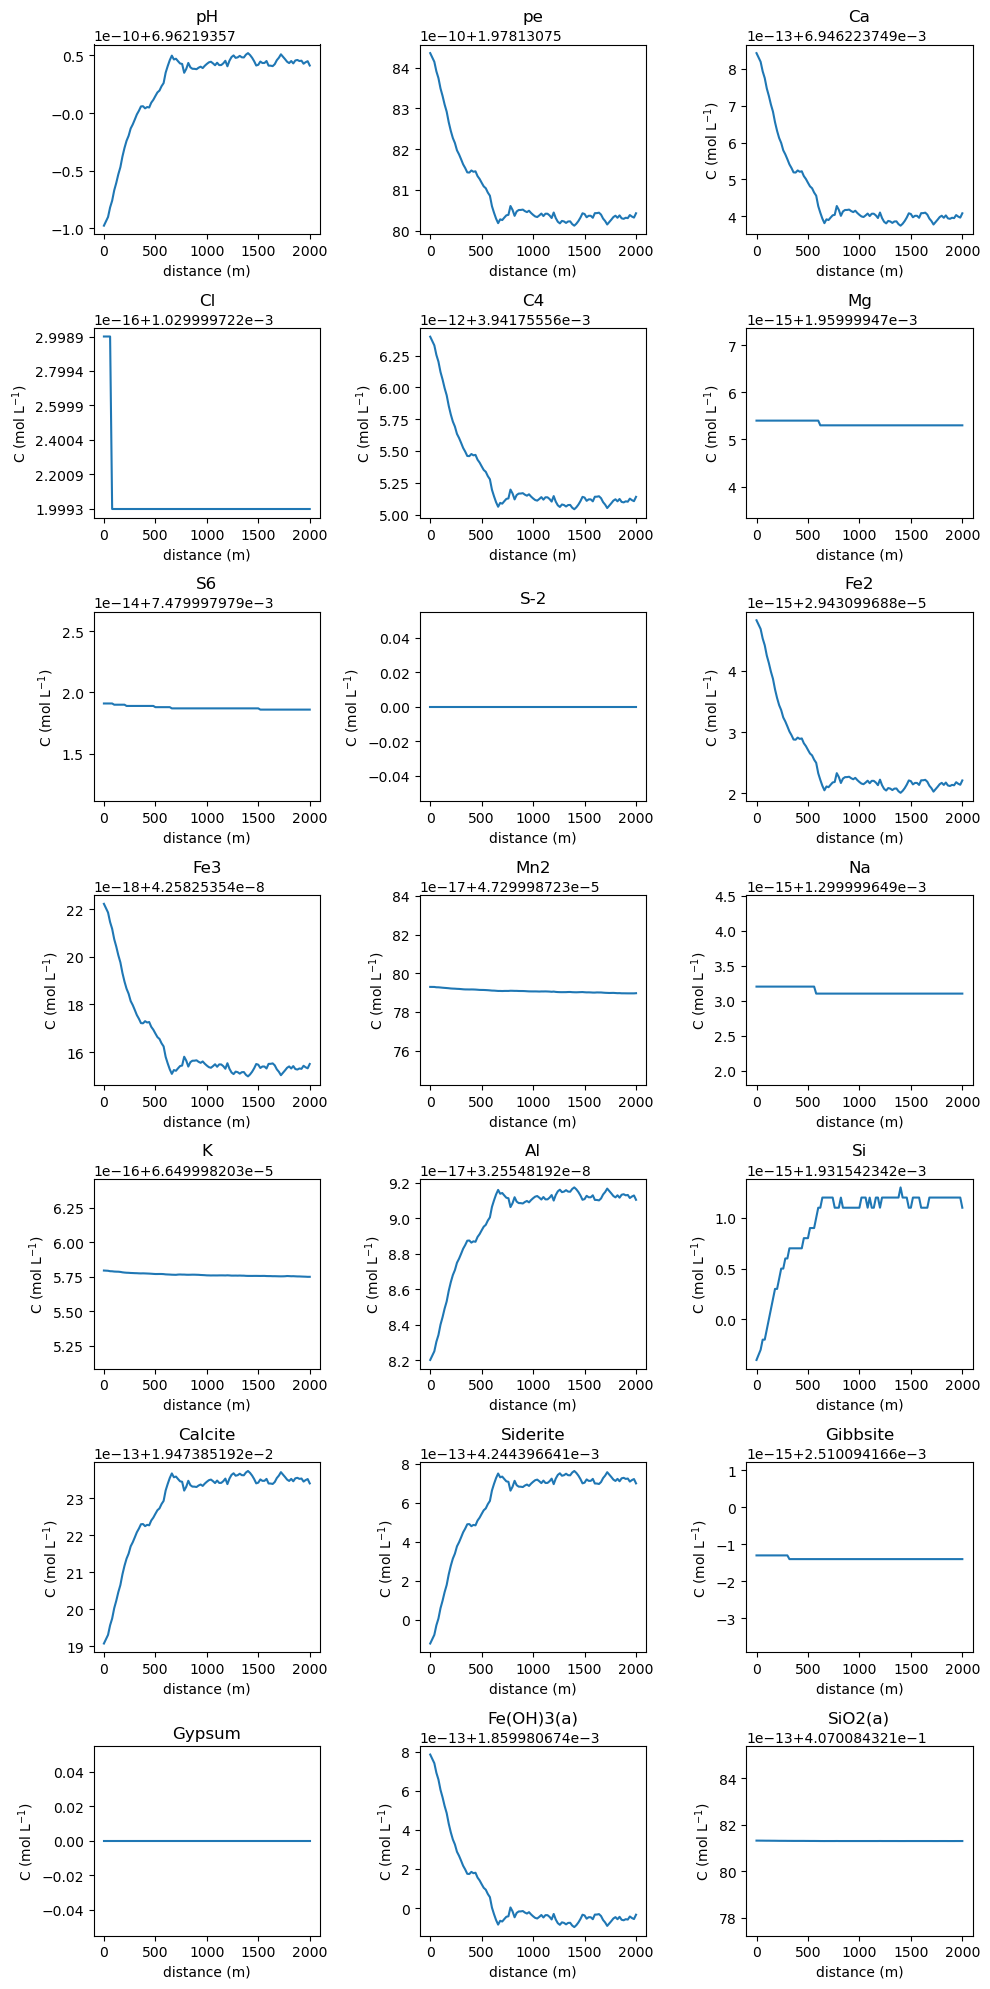

In [43]:
# wd = os.path.join('engesgaard1992_pht3d')
# dx = 0.01
# simdf = pd.read_csv(os.path.join(wd, 'out.dat'), sep = '\t', skipinitialspace=True, index_col=[0])
# simdf.drop(simdf.columns[len(simdf.columns)-1], axis=1, inplace=True)

# simdf.loc[:, 'x'] = simdf['cell'] * dx 
# simdf.drop(columns = 'H', inplace = True)

simapi = pd.read_csv(os.path.join(model.wd,'sout.csv'), sep = ',', skipinitialspace=True, index_col=[0])
simapi.loc[:, 'x'] = (simapi['cell'] + 1)*delr
# simapi = simapi[simdf.columns]

simapi
ncol=3
nrow = 7
fig, axs = plt.subplots(nrow,ncol, figsize = (10, 20))


for var, ax in zip(simapi.iloc[:,1:-1 ].columns, axs.flatten()):
    # ax.plot(simdf.x.unique(), simdf.loc[perlen, var], label = 'Engesgaard1992 - PHT3D')
    df = simapi[simapi['cell'] == 25.].copy()
    # ax.plot(simapi.x.unique(), simapi.loc[simapi.index.unique()[-1], var], label = 'Engesgaard1992 - MF6RTM')
    ax.plot(df.index, df.loc[:, var], label = 'Engesgaard1992 - MF6RTM')
    ax.set_xlabel('distance (m)')
    if var not in ['pH', 'pe']:
        ax.set_ylabel('C (mol L$^{-1}$)')
    ax.set_title(f'{var}')
    # ax.legend()
fig.tight_layout()

In [22]:
df.loc[df.index.unique()[-1], var]
df

,cell,pH,pe,Ca,Cl,C4,Mg,S6,S-2,Fe2,...,K,Al,Si,Calcite,Siderite,Gibbsite,Gypsum,Fe(OH)3(a),SiO2(a),x
time_d,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,5.143270,4.809452,0.013007,0.000119,0.007455,0.00097,0.032663,0.0,0.018013,...,0.000794,0.000002,0.001902,0.0,0.016783,0.006795,0.017310,0.001859,0.407179,4.0
40.0,0.0,5.143261,4.809477,0.013007,0.000119,0.007455,0.00097,0.032663,0.0,0.018013,...,0.000794,0.000002,0.001902,0.0,0.016783,0.006795,0.017310,0.001859,0.407179,4.0
60.0,0.0,5.143261,4.809477,0.013007,0.000119,0.007455,0.00097,0.032663,0.0,0.018013,...,0.000794,0.000002,0.001902,0.0,0.016783,0.006795,0.017309,0.001859,0.407179,4.0
80.0,0.0,5.143261,4.809477,0.013007,0.000119,0.007455,0.00097,0.032663,0.0,0.018013,...,0.000794,0.000002,0.001902,0.0,0.016782,0.006795,0.017309,0.001859,0.407179,4.0
100.0,0.0,5.143261,4.809477,0.013007,0.000119,0.007455,0.00097,0.032663,0.0,0.018013,...,0.000794,0.000002,0.001902,0.0,0.016782,0.006795,0.017309,0.001860,0.407179,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920.0,0.0,5.143261,4.809477,0.013007,0.000119,0.007455,0.00097,0.032663,0.0,0.018013,...,0.000794,0.000002,0.001902,0.0,0.016757,0.006795,0.017309,0.001884,0.407179,4.0
1940.0,0.0,5.143261,4.809477,0.013007,0.000119,0.007455,0.00097,0.032663,0.0,0.018013,...,0.000794,0.000002,0.001902,0.0,0.016757,0.006795,0.017309,0.001884,0.407179,4.0
1960.0,0.0,5.143261,4.809477,0.013007,0.000119,0.007455,0.00097,0.032663,0.0,0.018013,...,0.000794,0.000002,0.001902,0.0,0.016756,0.006795,0.017309,0.001885,0.407179,4.0
